In [1]:
# change this to process the desidered dataset
# allowed values are 'go_ny', 'go_sf', 'lastfm', 'reddit_top', 'tw_ny' and 'tw_oc' 
dataset_name = 'go_sf'

In [2]:
# All imports. 

# load coo_matrix from Scipy.sparse module.
from scipy.sparse import coo_matrix

# import numpy.
import numpy as np
from numpy import genfromtxt

# import pandas.
import pandas as pd

# import random.
import random
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly
import plotly.graph_objs as go
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot

# import sklearn.
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import MeanShift, KMeans
from sklearn.decomposition import NMF
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score, zero_one_loss,accuracy_score
from sklearn.model_selection import train_test_split

from itertools import cycle
import multiprocessing

%matplotlib inline

In [3]:
# hits parameter placeholder (will be computed based on current data).
hits_value = 0

In [4]:
# utility function to construct path/filename
def to_filename(dataset_name, dataset_type):
    # take a dataset name and its kind and return the path to it
    if dataset_type != 'figures':
        return '..//data//{}//{}.csv'.format(dataset_name, dataset_type)
    else:
        return '..//data//{}//figures'.format(dataset_name)

In [5]:
# load a dataset from a file in ijv/coomatrix and convert it to sparse dataframe
def load_dataset(filename):
    # import LAST FM dataset:
    # in the first comun we have the entry number, in the second the user id, 
    # in the third we have the item id, in the fourth we have the consumption number.
    ijv = genfromtxt(filename, delimiter=',',dtype=int)
    
    # coo matrix to have a matrix version of csv files. 
    cm = coo_matrix((ijv[:,2], (ijv[:,0], ijv[:,1])))
    # create the dataset: in this way more fast!
    sdf = pd.DataFrame(cm.toarray())
    
    # print memory usage.
    print("Memory usage: " + str(sdf.memory_usage(index=True).sum()))
    return sdf

In [6]:
# computes the dataset density value (number of significat values, > 0, among all)
def calculate_density_value(dataset):
    #calculate dendity values
    not_zeros = 0
    all_numbers = len(dataset) * len(dataset.iloc[0])
    density = 0

    #foreach row.
    for i, row in dataset.iterrows():
        #foreach item.
        for item in row:
            if item != 0:
                not_zeros += 1

    # calculate density
    density = (not_zeros/all_numbers)*100
    return density

In [7]:
# computes corrleation coefficient of the dataframe
def calculate_correlation(dataset):
    # search correlation between features.
    np.seterr(divide='ignore', invalid='ignore')
    corr = np.corrcoef(dataset, rowvar=False)
    return corr

In [8]:
# Plot the correlation matrix 
def plot_corr(dataset, corr, filename):
    # correlation plot: more yellow we have, more correlation it is.
    plotfig = plt.figure(figsize=(30,10))
    plt.matshow(corr, fignum=plotfig.number)
    #plt.xticks(range(dataset.shape[1]), dataset.columns, fontsize=14, rotation=45)
    #plt.yticks(range(dataset.shape[1]), dataset.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16);
    if not filename is None:
        plt.savefig(filename, dpi=100)
    plt.show()

In [9]:
# return a dataframe containing the sum (foreach user) of all consumed items.
# return the total mean of the consumption.
def count_user_consumed_items(dataset):    
    total_user_consumption = {} 
    #foreach row.
    for i, row in dataset.iterrows():
        # i is the row index.
        total_user_consumption[i] = row.sum()
    
    # convert to dataframe.
    total_user_consumption = pd.DataFrame.from_dict(total_user_consumption, orient='index' ,columns=['Sum'])

    # total user consumption mean.
    total_user_consumption_mean = total_user_consumption.mean(0)
    
    return total_user_consumption,total_user_consumption_mean

In [10]:
# plot a series of data with desider kind, mean, ticks size and label, optionally save it to a file
def plot_with_mean(plot_kind, dataset, mean, filename, nticks, fig_size, xlabel, ylabel):
    ax = dataset.plot(kind=plot_kind,figsize=fig_size, color='g')
    ticks = ax.xaxis.get_ticklocs()
    ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
    ax.xaxis.set_ticks(ticks[::nticks])
    ax.xaxis.set_ticklabels(ticklabels[::nticks])
    # a negative mean is "don't plot mean"
    if(mean>=0):
        plt.axhline(mean, color='red', linestyle='solid', linewidth=2)
    if not (xlabel is None):
        # set labels.
        ax.set(xlabel=xlabel)
    if not (ylabel is None):
        # set labels.
        ax.set(ylabel=ylabel)

    # save fig.
    plt.savefig(filename, dpi=100)

In [11]:
# plot the density distribution with kde curve
def plot_density(dataset,xlabel,ylabel):
    #plot density.
    sns.set(rc={'figure.figsize':(12,9)})
    ax = sns.distplot(dataset,rug=False, vertical=False,norm_hist=True,
                 label='Probability',
                 axlabel = 'Probability',
                 kde_kws={"color": "r", "lw": 3, "label": "KDE"},)
    
    if not (xlabel is None):
        # set labels.
        ax.set(xlabel=xlabel)
    if not (ylabel is None):
        # set labels.
        ax.set(ylabel=ylabel)
        
    
    # save figure.
    plt.savefig(fig_path + '//DistinctUserConsumptionHist.png', dpi=100)
    plt.show()

In [12]:
# count average number of distinct consumed items for user.
def count_distinct_user_consumption(dataset):
    total_distinct_user_consumption = {} 

    #foreach row.
    for i, row in dataset.iterrows():
        total_distinct_user_consumption[i] = row[row > 0.0].count()
    
    total_distinct_user_consumption = pd.DataFrame.from_dict(total_distinct_user_consumption, orient='index' ,columns=['Distinct Consumed Items'])
    
    return total_distinct_user_consumption

In [13]:
def calculate_user_unique_items (dataset):
    user_unique_items = {} # user unique items
    user_unique_items_ = {} #user unique items consumed more than 1
    user_unique_items_average = 0
    # percentage of user unique times consumed more than one.
    user_unique_items_percentage = 0

    for i, row in dataset.iterrows():
    
        user_unique_items[i] = 0
        user_unique_items_[i] = 0

        # column index
        j = 0
    
        # foreach item.
        for item in row:
            # if was consumed.
            if(item > 0):
            
                # access to column j.   
                column = dataset.iloc[:,[j]]
            
                # check if the element was consumed only by the current user. 
                wasConsumed = ((column > 0.0).apply(np.count_nonzero)==1).iloc[0]

                # check if is only consumed by this user.
                if wasConsumed: 
                    user_unique_items[i] += 1   
                
                    # update user unique items (it was consumed only by this user more than one time).
                    if(item > 1):
                        user_unique_items_[i] +=1
            #update index             
            j += 1        
    
    #conversions.
    user_unique_items = pd.DataFrame.from_dict(user_unique_items, orient='index' ,columns=['Nmber of items consumed only by the user']) 
    user_unique_items_ = pd.DataFrame.from_dict(user_unique_items_, orient='index' ,columns=['Number of items consumed only by the user more than one time']) 
    
    user_unique_items_average = user_unique_items.mean(0)
    
    # return elements.
    return user_unique_items, user_unique_items_,user_unique_items_average[0]

In [14]:
def calculate_repeated_consumption(dataset, total_user_consumption):
    total_repeat_consumption = {}
    percentage_repeate_consumption = 0

    # foreach row.
    for i, row in dataset.iterrows():
        total_repeat_consumption[i] = row[row > 1.0].sum()
    
    #conversion
    total_repeat_consumption = pd.DataFrame.from_dict(total_repeat_consumption, orient='index' ,columns=['Percentage of repeat Consumption'])

    #sum of all repeat consumption/ sum of all consumption.
    percentage_repeated_consumption = (total_repeat_consumption.sum()[0]/total_user_consumption.sum()[0])*100
    
    return percentage_repeated_consumption

In [15]:
def gini(arr):
    count = arr.size
    coefficient = 2 / count
    indexes = np.arange(1, count + 1)
    weighted_sum = (indexes * arr).sum()
    total = arr.sum()
    constant = (count + 1) / count
    return coefficient * weighted_sum / total - constant

def lorenz(arr):
    # this divides the prefix sum by the total sum
    # this ensures all the values are between 0 and 1.0
    scaled_prefix_sum = arr.cumsum() / arr.sum()
    # this prepends the 0 value (because 0% of all people have 0% of all wealth)
    return np.insert(scaled_prefix_sum, 0, 0)

def plot_gini_curve(dataset, fig_size, filename):
    arr = np.sort(np.array(dataset).ravel())

    lorenz_curve = lorenz(arr)

    # we need the X values to be between 0.0 to 1.0
    plt.figure(figsize=fig_size, dpi=80)
    plt.plot(np.linspace(0.0, 1.0, lorenz_curve.size), lorenz_curve)
    # plot the straight line perfect equality curve
    plt.plot([0,1], [0,1])
    plt.savefig(filename, dpi=100)
    return gini(arr)

In [16]:
# find "hits": number of user that listen a song.
def calculate_hits(dataset):
    total_item_distinct_consumption = {}
    hits = {}

    #foreach column.
    for i, column in dataset.iteritems():
        total_item_distinct_consumption[i] = column[column > 0.0].count()
        # if is an hit (was listend more than hits value times).
        if(total_item_distinct_consumption[i] >= hits_value):
            # save value
            hits[i] = total_item_distinct_consumption[i]

    #conversion.
    total_item_distinct_consumption = pd.DataFrame.from_dict(total_item_distinct_consumption, orient='index' ,columns=['Hits'])
  
    # total user distinct consumption mean.
    total_item_distinct_consumption_mean  = total_item_distinct_consumption.mean(0)

    return total_item_distinct_consumption, total_item_distinct_consumption_mean, hits 

In [17]:
def calculate_hits_deltas(hits, validation_hits):
    # calculate new hits, old hits
    new_hits = {}
    old_hits = {}
    stable_hits = {}

    # foreach hit in the hits dict.
    for key, value in hits.items():
        # if it is inside validation hits.
        if(key in validation_hits):
            # update stable hit.
            stable_hits[key] = value
        else:
            #update old_hits.
            old_hits[key] = value

    # foreach hit in the validation dict.        
    for key, value in validation_hits.items():    
        if not(key in hits):
            # it is a new hit.
            new_hits[key] = value
            
    return old_hits, new_hits, stable_hits        

In [18]:
def calculate_exploration_rate(dataset, val_dataset, dataset_tuc):
    # calculate percentage of new consumption in the validation set.

    user_train_consumption = []

    #foreach row.
    for i, row in dataset.iterrows():
    
        # column index.
        j = 0
        user_consumption = {}
        # foreach element.
        for item in row:
            #it has been consumed.
            if(item > 0):
                # add the item as consumed inside the array of dicts.
                user_consumption[j] = item
            # update column index.
            j +=1
        user_train_consumption.append(user_consumption)

    # dict to store the number of item has been explored.
    user_exploration = {}
    # dict to store the number of distinct new consumption.
    user_distinct_exploration = {}


    # foreach user i.
    for i, row in val_dataset.iterrows():
    
        #update distinct new consumption.
        user_distinct_exploration[i] = 0
        # update user exploration.
        user_exploration[i] = 0
    
        # column index.
        j = 0
        # foreach element.
        for item in row:
            #it has been consumed.
            if(item > 0):
            
                # if the j item has been previously consumed.
                if not(j in user_train_consumption[i]):
                
                    # update distinct new consumption.
                    user_exploration[i] += item
                    # update user exploration.
                    user_distinct_exploration[i] += 1

            # update column index.
            j +=1

    exploration_rate = {}       
    exploration_rate_mean = 0
        
    # calculate exploration user rate.
    for i in range(len(user_exploration)):
        # we divide the exploration consumed item for the total consumption.
        exploration_rate[i] = (user_exploration[i]/dataset_tuc.iloc[i][0])*100
    
    # remove nan values and make the mean.
    exploration_rate_mean = np.nan_to_num(np.array(list(exploration_rate.values()))).mean()
    
    return exploration_rate, exploration_rate_mean, user_distinct_exploration

In [19]:
def MeanShiftCluster(lastfmT, elements_to_cluster):
    # make mean shift clustering. 
    
    jobs = (multiprocessing.cpu_count()-1)
    if(jobs<1): jobs=1
    ms = MeanShift(n_jobs = jobs, bin_seeding=True)
    ms.fit_predict(lastfmT.iloc[:elements_to_cluster].values)
    cluster_centers =  ms.cluster_centers_
    # è un array monodimensionale con n righe tante quante sono le righe del dataset e
    # il numero contenuto è il cluster a cui appartiene quella riga (indice)
    labels = ms.labels_
    labels_unique = np.unique(labels)
    n_clusters = len(labels_unique)
    
    return labels, labels_unique, n_clusters, cluster_centers
    


In [20]:
def clusterAndPlot(datasetT, range_n_clusters):

    cmap = cm.get_cmap("Spectral")

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(datasetT) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(datasetT)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(datasetT, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(datasetT, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cmap(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cmap(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(datasetT.iloc[:, 0], datasetT.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

# MAIN

In [21]:
# generate folder/path
fig_path = to_filename(dataset_name,'figures')
filename = to_filename(dataset_name, 'train')

In [22]:
# open the dataset.
lastfm = load_dataset(filename)

Memory usage: 159853344


In [23]:
hits_value = len(lastfm)/10


In [24]:
lastfm_describe = lastfm.describe()
lastfm_describe

0            1            2            3            4     \
count  2593.000000  2593.000000  2593.000000  2593.000000  2593.000000   
mean      0.137293     0.007713     0.005399     0.001157     0.105283   
std       0.764046     0.095915     0.087675     0.034001     0.460750   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max      29.000000     2.000000     3.000000     1.000000     7.000000   

              5            6            7            8            9     ...  \
count  2593.000000  2593.000000  2593.000000  2593.000000  2593.000000  ...   
mean      0.057077     0.008870     0.012341     0.006170     0.021982  ...   
std       0.357650     0.239595     0.201848     0.078325     0.177590  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
50%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
75%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
max       8.000000    10.000000     7.000000     1.000000     4.000000  ...   

         7696    7697    7698    7699    7700    7701    7702    7703    7704  \
count  2593.0  2593.0  2593.0  2593.0  2593.0  2593.0  2593.0  2593.0  2593.0   
mean      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
std       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
min       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
25%       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
50%       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
75%       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
max       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

         7705  
count  2593.0  
mean      0.0  
std       0.0  
min       0.0  
25%       0.0  
50%       0.0  
75%       0.0  
max       0.0  

[8 rows x 7706 columns]

Mean:  324.5962968582738


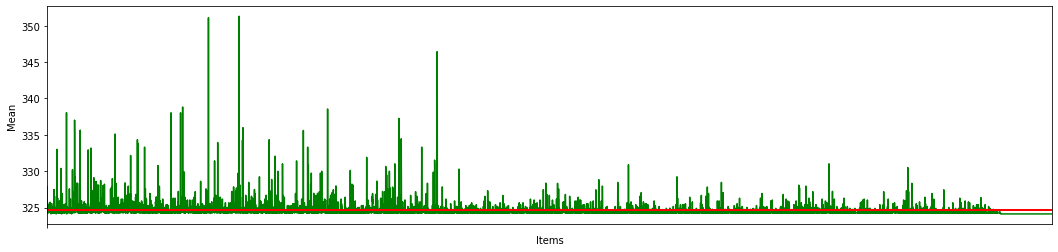

In [25]:
dmean = lastfm_describe.mean().mean()
outputfile = fig_path + "//mean_bar.png"
plot_with_mean('line', lastfm_describe.mean(), dmean, outputfile, 1000, (18,4), "Items", "Mean")
print("Mean: ", dmean)

Mean of Std. Dev:  916.5787420226038


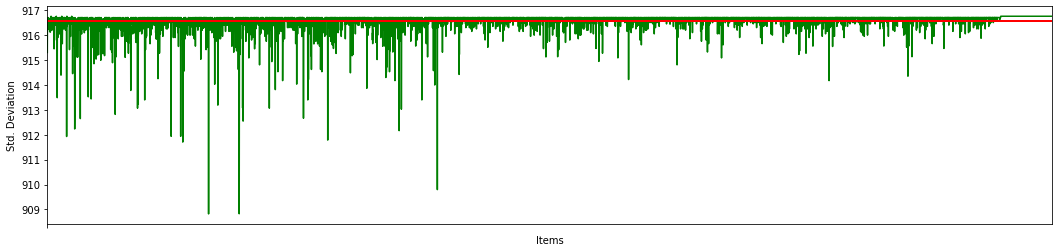

In [26]:
stdmean = lastfm_describe.std().mean()
outputfile = fig_path + "//stdev_bar.png"
plot_with_mean('line', lastfm_describe.std(), stdmean, outputfile, 1000, (18,4), "Items", "Std. Deviation")
print("Mean of Std. Dev: ", stdmean)

In [27]:
lastfm_corr = calculate_correlation(lastfm)

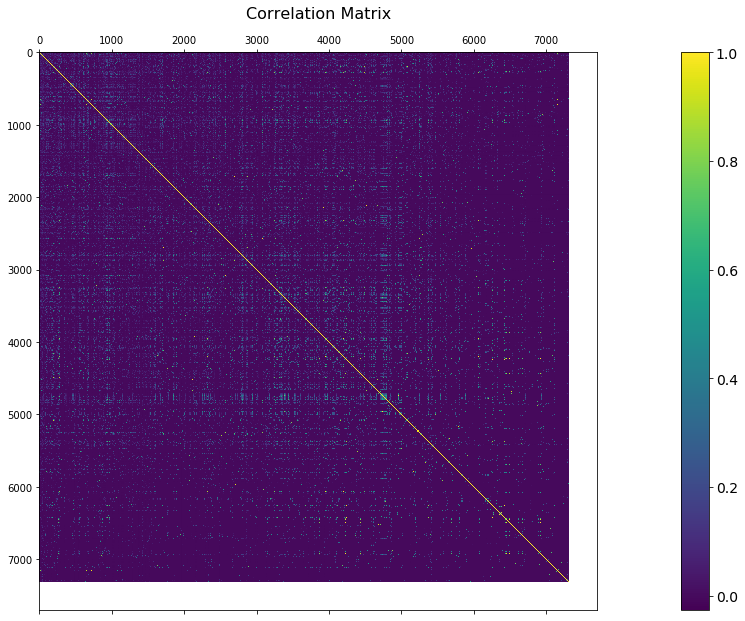

In [28]:
outputfile = fig_path + '//CorrPlot.png'
plot_corr(lastfm, lastfm_corr, outputfile)

user total consumption mean: 38.52371770150405


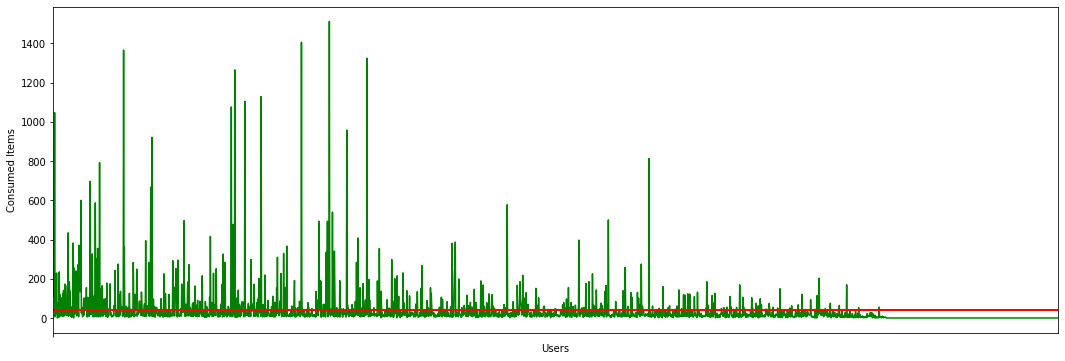

In [29]:
# calculate user total consumption and its mean.
lastfm_tuc, lastfm_tuc_mean  = count_user_consumed_items(lastfm)
print("user total consumption mean:" ,lastfm_tuc_mean[0])
# plot it.
outputfile = fig_path + "//tuc_hist.png"
plot_with_mean('line', lastfm_tuc.iloc[:,0], lastfm_tuc_mean[0], outputfile, 30, (18,6), "Users", "Consumed Items")

Distinct user consumption mean: 24.332433474739684


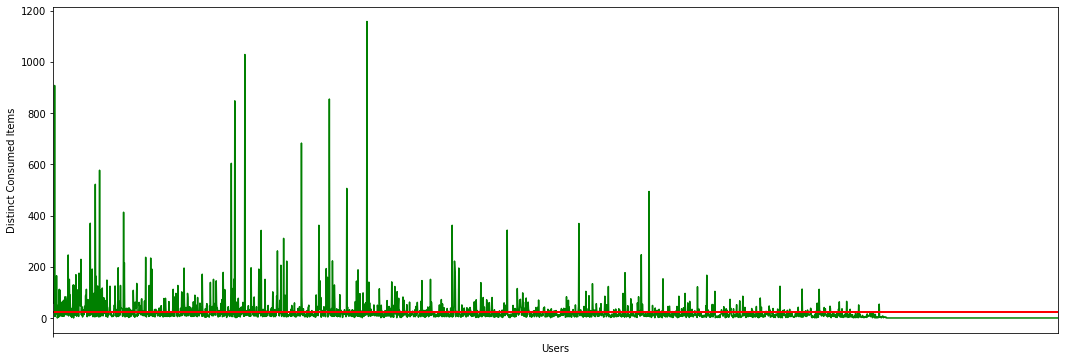

In [30]:
# count average number of distinct consumed items for user and its mean.
lastf_distinct_user_consumption = count_distinct_user_consumption(lastfm)
lastf_distinct_user_consumption_mean = lastf_distinct_user_consumption.mean(0)
print("Distinct user consumption mean:" , lastf_distinct_user_consumption_mean[0])
# plot it.
outputfile = fig_path + "//astf_distinct_consumption_hist.png"
plot_with_mean("line", lastf_distinct_user_consumption.iloc[:,0], lastf_distinct_user_consumption_mean[0], outputfile, 30, (18,6), "Users", "Distinct Consumed Items")

Train dataset Density: 0.3157595831136735%


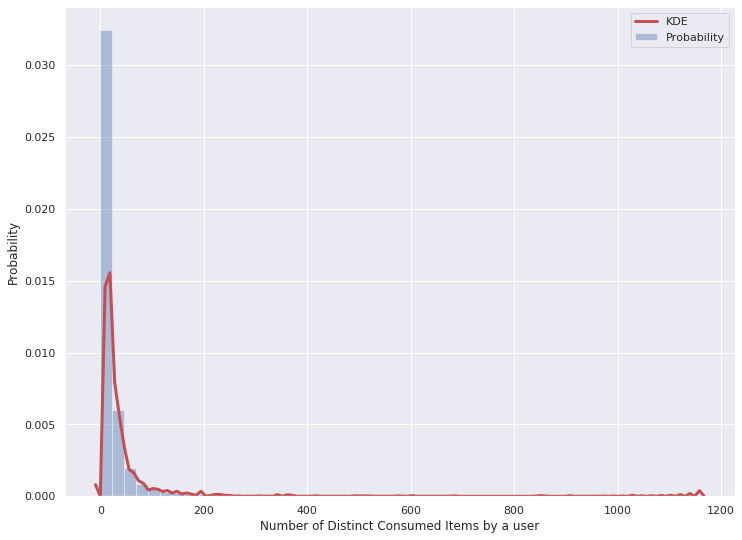

In [31]:
# calculate density.
lastfm_density = calculate_density_value(lastfm)
print("Train dataset Density: " + str(lastfm_density) + "%")

# plot density.
plot_density(lastf_distinct_user_consumption,'Number of Distinct Consumed Items by a user','Probability')

In [32]:
%%time

user_unique_items, user_unique_items_,user_unique_items_average = calculate_user_unique_items(lastfm)

print("Mean number of items consumed by a only user: " , user_unique_items_average)
user_unique_items_percentage = (user_unique_items_.sum()[0]/user_unique_items.sum()[0])*100
print("Percentage of unique items consumed more than one time: " + str(user_unique_items_percentage) + "%")

Mean number of items consumed by a only user:  0.2645584265329734
Percentage of unique items consumed more than one time: 54.22740524781341%
CPU times: user 4min 19s, sys: 909 ms, total: 4min 20s
Wall time: 4min 20s


In [33]:
%%time
percentage_repeated_consumption = calculate_repeated_consumption(lastfm, lastfm_tuc)
print("Percentage of repeat consumption (Train dataset): " + str(percentage_repeated_consumption) + "%")

Percentage of repeat consumption (Train dataset): 48.56044528090337%
CPU times: user 2.73 s, sys: 79.5 ms, total: 2.8 s
Wall time: 2.86 s


Gini Coefficient of dataset:  0.9979098120529153


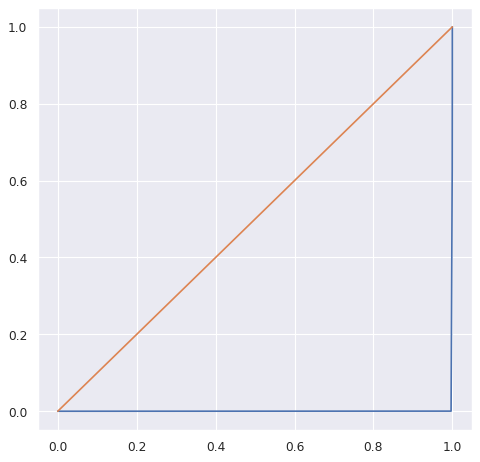

In [34]:
outputfile = fig_path + "//gini_curve.png"
lastfm_gini_coeff = plot_gini_curve(lastfm, (7, 7), outputfile)

print("Gini Coefficient of dataset: ", str(lastfm_gini_coeff))

In [35]:
# number of distinct user that consumes an item
total_item_distinct_consumption, total_item_distinct_consumption_mean, hits = calculate_hits(lastfm)
print("user distinct total consumption mean:" , total_item_distinct_consumption_mean[0])

user distinct total consumption mean: 8.187645990137556


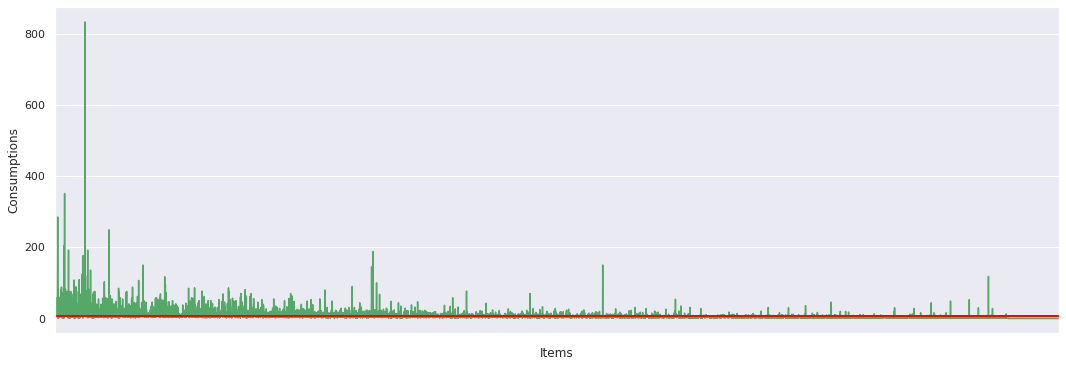

In [36]:
outputfile = fig_path + "//distinct_consumption.png"
plot_with_mean('line', total_item_distinct_consumption.iloc[:,0], total_item_distinct_consumption_mean[0], outputfile, 500, (18,6), "Items", "Consumptions")

## VALIDATION

In [37]:
# open last fm dataset (validation).
filename = to_filename(dataset_name, 'validation')
lastfmval = load_dataset(filename)

Memory usage: 159853344


In [38]:
# normalize the time (3y->3m)
hits_value = hits_value/12 

In [39]:
lastfmval_describe = lastfmval.describe()
lastfmval_describe

0            1       2       3            4            5     \
count  2593.000000  2593.000000  2593.0  2593.0  2593.000000  2593.000000   
mean      0.040108     0.001543     0.0     0.0     0.028924     0.009641   
std       0.228917     0.039253     0.0     0.0     0.191274     0.122284   
min       0.000000     0.000000     0.0     0.0     0.000000     0.000000   
25%       0.000000     0.000000     0.0     0.0     0.000000     0.000000   
50%       0.000000     0.000000     0.0     0.0     0.000000     0.000000   
75%       0.000000     0.000000     0.0     0.0     0.000000     0.000000   
max       4.000000     1.000000     0.0     0.0     3.000000     3.000000   

              6            7            8            9     ...    7696  \
count  2593.000000  2593.000000  2593.000000  2593.000000  ...  2593.0   
mean      0.001157     0.004242     0.001928     0.003857  ...     0.0   
std       0.034001     0.112754     0.051932     0.078473  ...     0.0   
min       0.000000     0.000000     0.000000     0.000000  ...     0.0   
25%       0.000000     0.000000     0.000000     0.000000  ...     0.0   
50%       0.000000     0.000000     0.000000     0.000000  ...     0.0   
75%       0.000000     0.000000     0.000000     0.000000  ...     0.0   
max       1.000000     5.000000     2.000000     3.000000  ...     0.0   

         7697    7698    7699    7700    7701    7702    7703    7704    7705  
count  2593.0  2593.0  2593.0  2593.0  2593.0  2593.0  2593.0  2593.0  2593.0  
mean      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
std       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
min       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
25%       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
50%       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
75%       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
max       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[8 rows x 7706 columns]

In [40]:
lastfmval_corr = calculate_correlation(lastfmval)

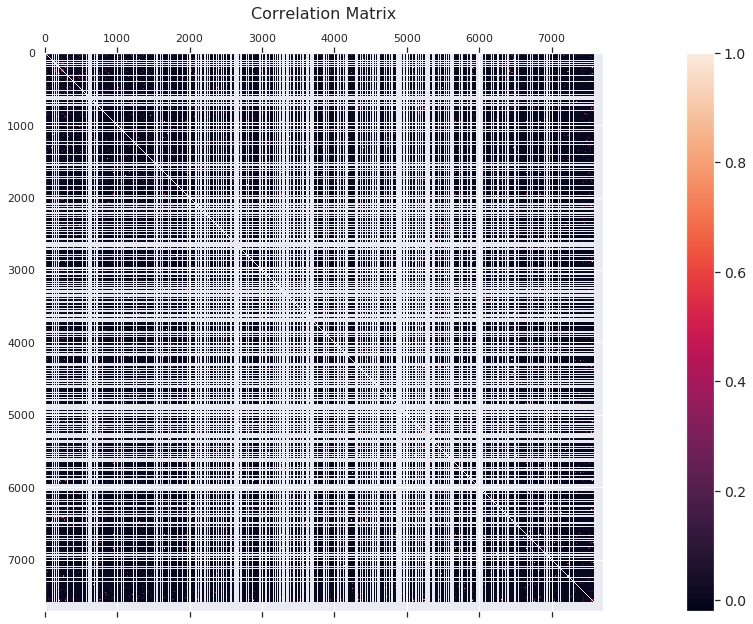

In [41]:
outputfile = fig_path + '//val_CorrPlot.png'
plot_corr(lastfmval, lastfmval_corr, outputfile)

user total consumption mean: 8.279598920169688


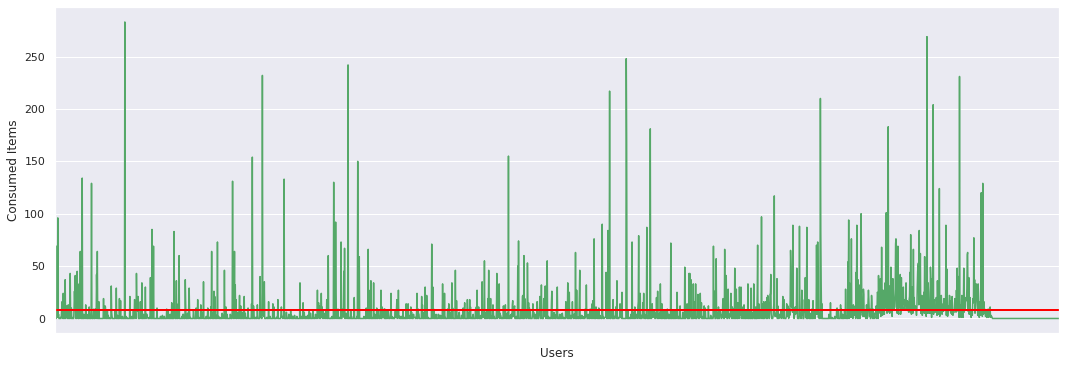

In [42]:
# calculate user total consumption and its mean.
lastfmval_tuc, lastfmval_tuc_mean  = count_user_consumed_items(lastfmval)
print("user total consumption mean:" ,lastfmval_tuc_mean[0])
# plot it.
outputfile = fig_path + "//val_tuc_hist.png"
plot_with_mean('line', lastfmval_tuc.iloc[:,0], lastfmval_tuc_mean[0], outputfile, 30, (18,6),"Users", "Consumed Items")

user distinct total consumption mean: 5.9730042421905125


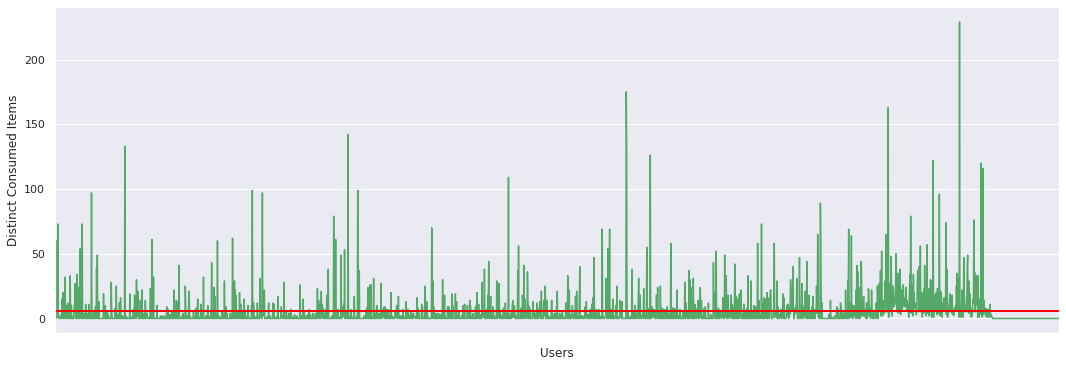

In [43]:
# count average number of distinct consumed items for user and its mean.
lastfval_distinct_consumption = count_distinct_user_consumption(lastfmval)
lastfval_distinct_consumption_mean = lastfval_distinct_consumption.mean(0)
print("user distinct total consumption mean:" , lastfval_distinct_consumption_mean[0])
# plot it.
outputfile = fig_path + "//val_astf_distinct_consumption_hist.png"
plot_with_mean('line',lastfval_distinct_consumption.iloc[:,0], lastfval_distinct_consumption_mean[0], outputfile, 30, (18,6),"Users", "Distinct Consumed Items")

Train dataset Density: 0.07751108541643541%


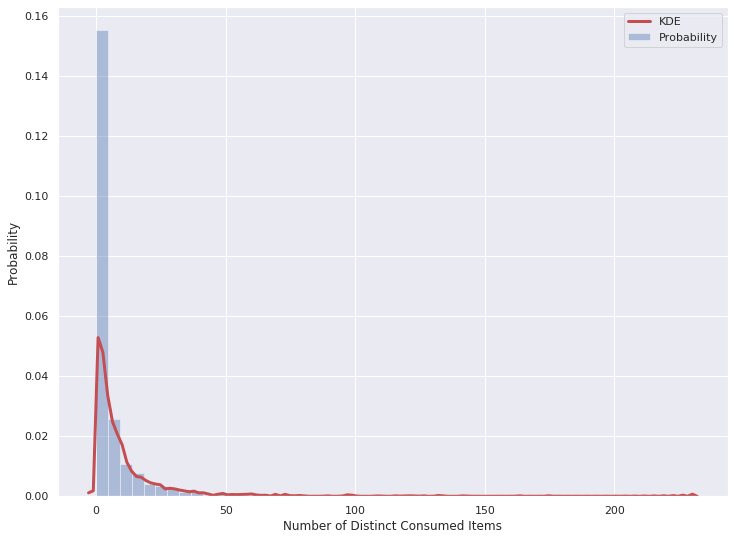

In [44]:
# calculate density.
lastfmval_density = calculate_density_value(lastfmval)
print("Train dataset Density: " + str(lastfmval_density) + "%")

# plot density.
plot_density(lastfval_distinct_consumption,'Number of Distinct Consumed Items','Probability')

In [45]:
%%time

val_user_unique_items, val_user_unique_items_, val_user_unique_items_average = calculate_user_unique_items(lastfmval)

print("Mean number of items consumed by a only user: " , val_user_unique_items_average)
val_user_unique_items_percentage = (val_user_unique_items_.sum()[0]/val_user_unique_items.sum()[0])*100
print("Percentage of unique items consumed more than one time: " + str(val_user_unique_items_percentage) + "%")

Mean number of items consumed by a only user:  0.8118010026995758
Percentage of unique items consumed more than one time: 17.387173396674584%
CPU times: user 1min 6s, sys: 50.2 ms, total: 1min 6s
Wall time: 1min 6s


In [46]:
%%time
val_percentage_repeated_consumption = calculate_repeated_consumption(lastfmval, lastfmval_tuc)
print("Percentage of repeat consumption (Validation dataset): " + str(val_percentage_repeated_consumption) + "%")

Percentage of repeat consumption (Validation dataset): 38.43681587405096%
CPU times: user 2.7 s, sys: 48 ms, total: 2.74 s
Wall time: 2.76 s


Gini Coefficient of validation dataset:  0.9994251124860649


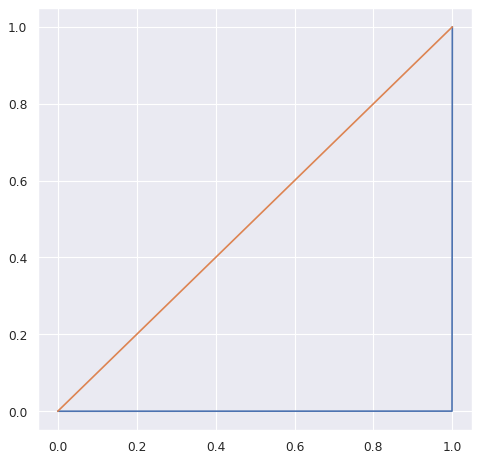

In [47]:
outputfile = fig_path + "//val_gini_curve.png"
lastfmval_gini_coeff = plot_gini_curve(lastfmval, (7, 7), outputfile)

print("Gini Coefficient of validation dataset: ", str(lastfmval_gini_coeff))

In [48]:
# number of distinct user that consumes an item
val_total_item_distinct_consumption, val_total_item_distinct_consumption_mean, val_hits = calculate_hits(lastfmval)
print("user distinct total consumption mean:" , val_total_item_distinct_consumption_mean[0])

user distinct total consumption mean: 2.0098624448481703


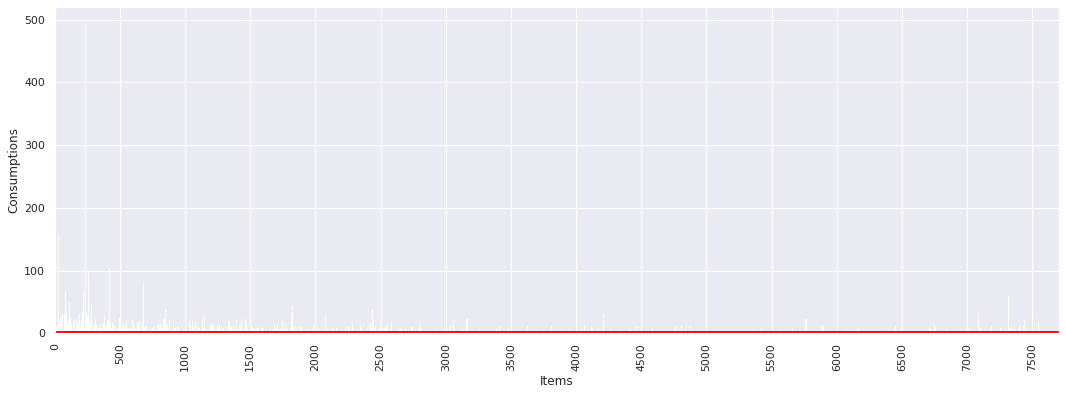

In [49]:
outputfile = fig_path + "//val_distinct_consumption.png"
plot_with_mean('bar',val_total_item_distinct_consumption.iloc[:,0], val_total_item_distinct_consumption_mean[0], outputfile, 500, (18,6), "Items", "Consumptions")

In [50]:
old_hits, new_hits, stable_hits = calculate_hits_deltas(hits, val_hits)
# calculate length of hits dicts. 
number_of_hits = len(hits)
number_of_validation_hits = len(val_hits)
number_of_new_hits = len(new_hits)
number_of_old_hits = len(old_hits)
number_of_stable_hits = len(stable_hits)

print("Number of hits (train dataset): " + str(number_of_hits))
print("Number of hits (validation dataset): " + str(number_of_validation_hits))
print("Number of new hits: " + str(number_of_new_hits))
print("Number of old hits: " + str(number_of_old_hits))
print("Number of stable hits: " + str(number_of_stable_hits))

# calculate percentage of new hits inside validation set.
percentage_of_new_hits = (number_of_new_hits/number_of_validation_hits)*100

# calculate percentage of old hits inside TRAIN set.
percentage_of_old_hits = (number_of_old_hits/number_of_hits)*100

# calculate percentage of stable hits inside validation set.
percentage_of_stable_hits = (number_of_stable_hits/number_of_validation_hits)*100


print("\nPercentage of new hits: " + str(percentage_of_new_hits) + "%")
print("Percentage of old hits: " + str(percentage_of_old_hits) + "%")
print("Percentage of stable hits: " + str(percentage_of_stable_hits) + "%")

Number of hits (train dataset): 3
Number of hits (validation dataset): 57
Number of new hits: 54
Number of old hits: 0
Number of stable hits: 3

Percentage of new hits: 94.73684210526315%
Percentage of old hits: 0.0%
Percentage of stable hits: 5.263157894736842%


In [51]:
# calculate exploration rate.
exploration_rate, exploration_rate_mean, user_distinct_exploration = calculate_exploration_rate(lastfm, lastfmval, lastfmval_tuc)
print("Exploration rate (validation dataset): " + str(exploration_rate_mean) + "%")

Exploration rate (validation dataset): 38.74478929650691%


In [52]:
# calculate exploration rate related to the item distinct consumption.
distinct_exploration_rate = {}       
distinct_exploration_rate_mean = 0

for i in range(len(user_distinct_exploration)):
    # we divide the exploration consumed item for the total consumption.
    distinct_exploration_rate[i] = (user_distinct_exploration[i]/lastfmval_tuc.iloc[i][0])*100

# remove nan values and make the mean.
distinct_exploration_rate_mean = np.nan_to_num(np.array(list(distinct_exploration_rate.values()))).mean()
print("Distinct exploration rate (validation dataset): " + str(distinct_exploration_rate_mean) + "%")

Distinct exploration rate (validation dataset): 35.037900304358516%


# TEST

### MEANSHIFT CLUSTERING

In [53]:
%%time

lastfmT = lastfm.T
elements_to_cluster=len(lastfmT)

labels, labels_unique, n_clusters, cluster_centers = MeanShiftCluster(lastfmT, elements_to_cluster)

print("Number of clusters:", n_clusters)

Number of clusters: 449
CPU times: user 23min 11s, sys: 1min 23s, total: 24min 34s
Wall time: 24min 34s


In [54]:
cluster = [ ] 

# for each color and number of cluster.
for k in range(n_clusters):
    # if we have the k element is a label
    # segna a True gli indici del dataset che appartengono al cluster "k"
    my_members = labels == k
    # save cluster center k.
    cluster_center = cluster_centers[k]
    # seleziona colore
    mycolor = matplotlib.colors.colorConverter.to_rgb(matplotlib.pyplot.cm.Spectral(float(k) / n_clusters, 1))
    mycolor ='rgb'+str(mycolor)

    row = lastfmT.iloc[:elements_to_cluster].values[my_members, 3]
    col = lastfmT.iloc[:elements_to_cluster].values[my_members, 4]
        
    #plot cluster.
    trace = go.Scatter(x=lastfmT.iloc[:elements_to_cluster].values[my_members, 3], 
                       y=lastfmT.iloc[:elements_to_cluster].values[my_members, 4], 
                       mode='markers', showlegend=False, name='Cluster'+str(k),
                       marker= dict(color=mycolor, size=10,))
    
    # plot cluster center.
    trace1 = go.Scatter(x=[cluster_center[0]], y=[cluster_center[1]], 
                        mode='markers',  showlegend=False,
                        marker=dict(color=mycolor, size=20,
                               line=dict(color = 'black',
                                           width = 1)))
    cluster.append(trace)
    cluster.append(trace1)

In [55]:
silhouette_avg = silhouette_score(lastfmT.iloc[:elements_to_cluster].values, labels)
print("For n_clusters =", n_clusters,", the average silhouette_score is :", silhouette_avg)

For n_clusters = 449 , the average silhouette_score is : 0.3149517908211561


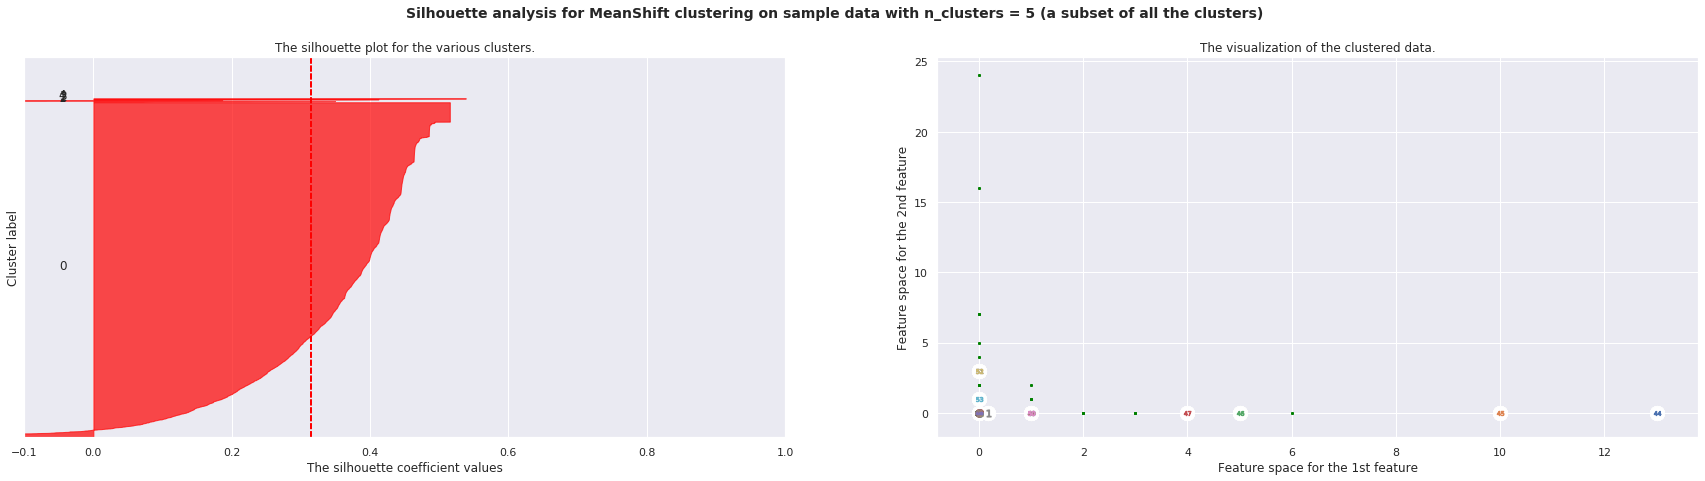

CPU times: user 38 s, sys: 743 ms, total: 38.7 s
Wall time: 35.7 s


In [56]:
%%time
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(lastfmT.iloc[:elements_to_cluster].values, labels)

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(30, 7)

n_clusters = 5

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
#lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(lastfmT) + (n_clusters + 1) * 10])
y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    # seleziona colore
    #color = matplotlib.colors.colorConverter.to_rgb(matplotlib.pyplot.cm.Spectral(float(i) / n_clusters, 1))
    #color ='rgb'+str(color)
    color = 'red'
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    #colors = cm.spectral(labels.astype(float) / n_clusters)
    colors='green'
    ax2.scatter(lastfmT.iloc[:, 0], lastfmT.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Draw white circles at cluster centers
    ax2.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(cluster_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for MeanShift clustering on sample data "
                  "with n_clusters = %d (a subset of all the clusters)" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.savefig("silhouette_" +str(i))
plt.show()

### K-MEANS CLUSTERING

For n_clusters = 2 The average silhouette_score is : 0.9594986553061055


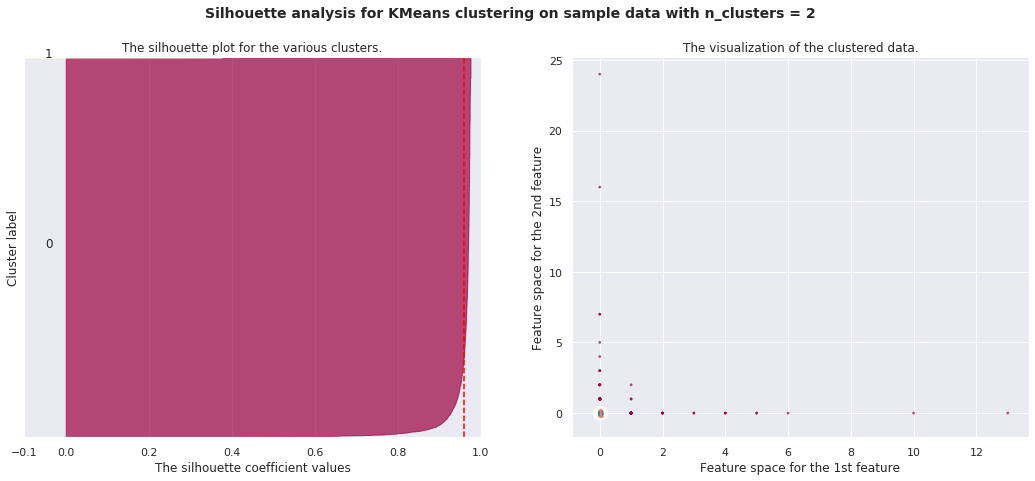

For n_clusters = 10 The average silhouette_score is : 0.8689599075031855


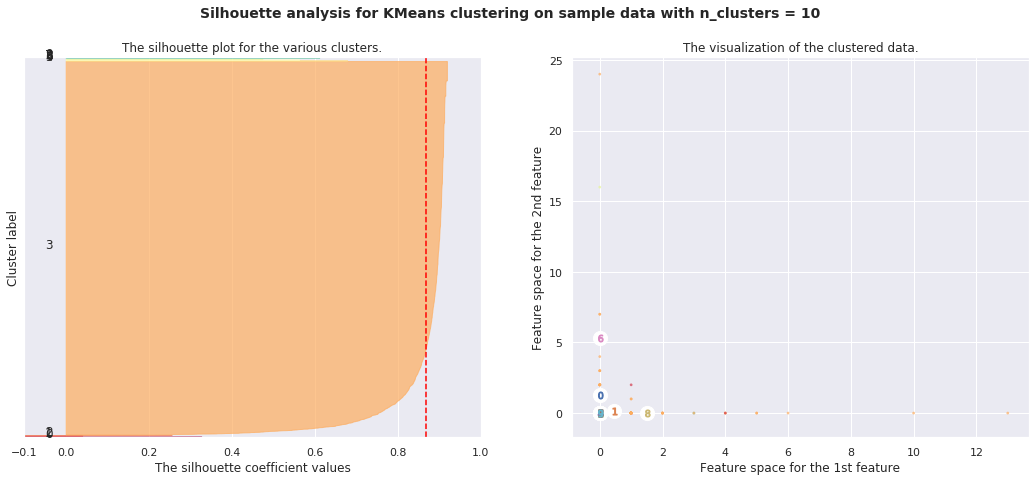

For n_clusters = 20 The average silhouette_score is : 0.8704771529868744


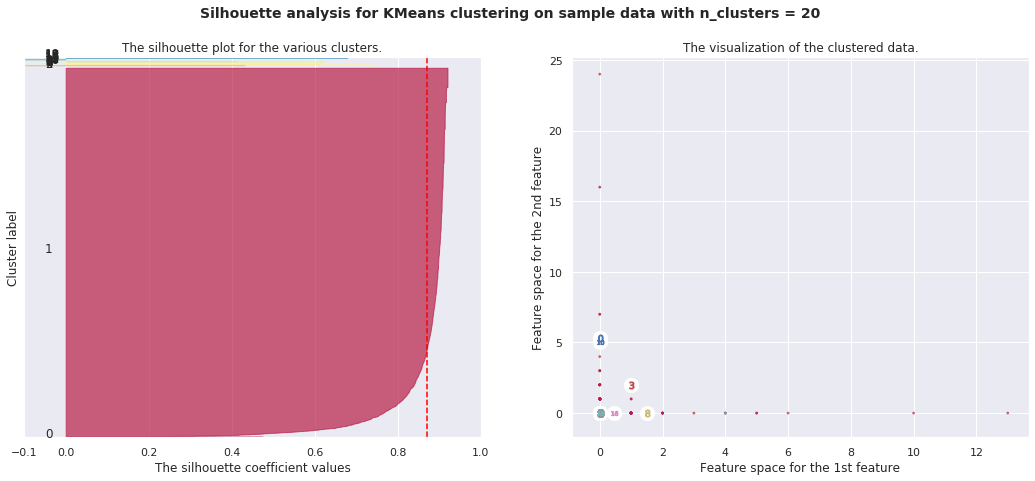

For n_clusters = 50 The average silhouette_score is : 0.4563268442330012


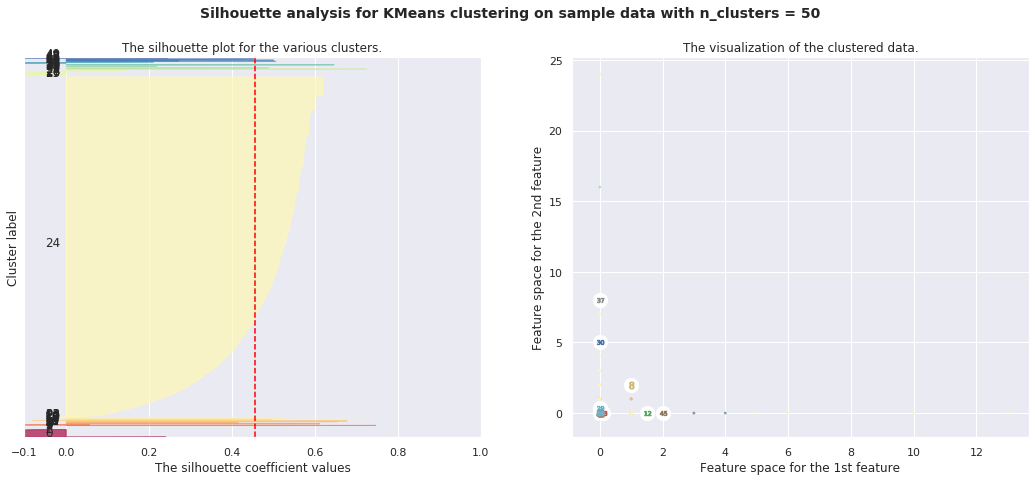

CPU times: user 2min 54s, sys: 7.74 s, total: 3min 1s
Wall time: 1min 40s


In [57]:
%%time
range_n_clusters = [2, 10, 20, 50]

clusterAndPlot(lastfmT, range_n_clusters)

### Using NMF with Clustering

In [89]:
%%time
## Try to use NMF for clustering (feature selection)
model = NMF(n_components = 50, init='random', random_state=0, verbose=False)
W = model.fit_transform(lastfm)
H = model.components_

CPU times: user 32.1 s, sys: 92.6 ms, total: 32.1 s
Wall time: 34.2 s


For n_clusters = 2 The average silhouette_score is : 0.9929867593197254


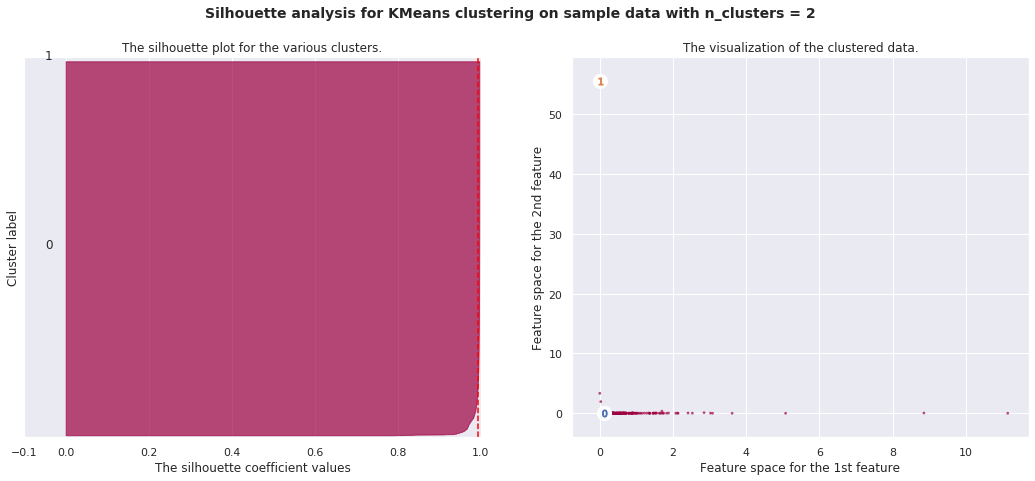

For n_clusters = 3 The average silhouette_score is : 0.957691559928398


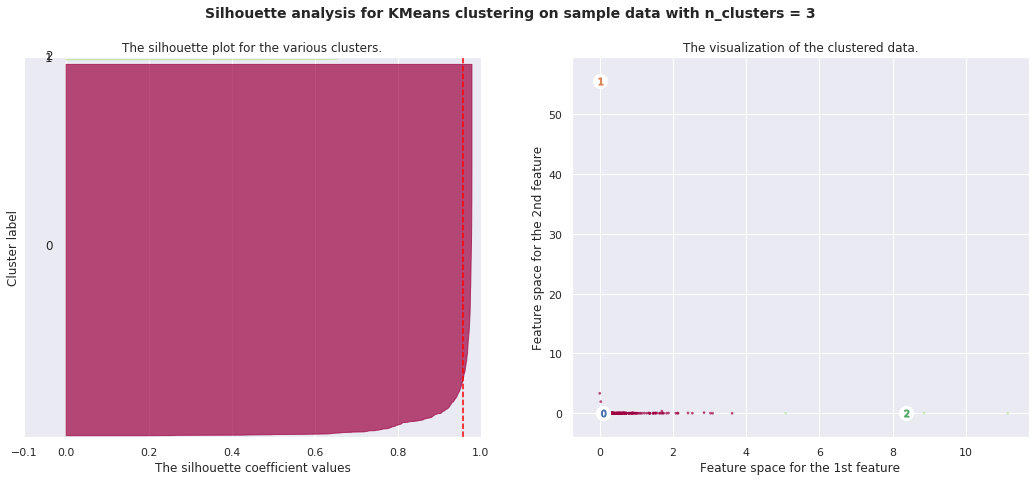

For n_clusters = 4 The average silhouette_score is : 0.9583813337926886


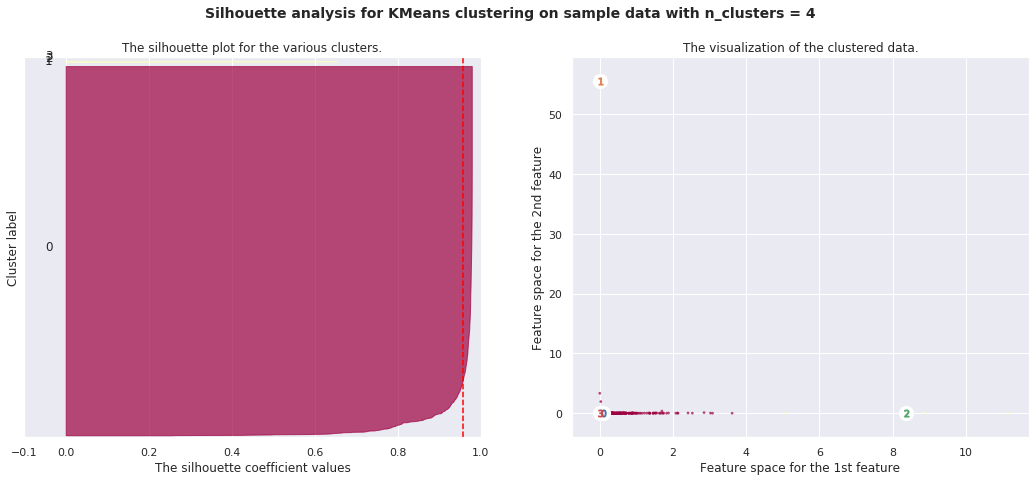

For n_clusters = 5 The average silhouette_score is : 0.82302430018521


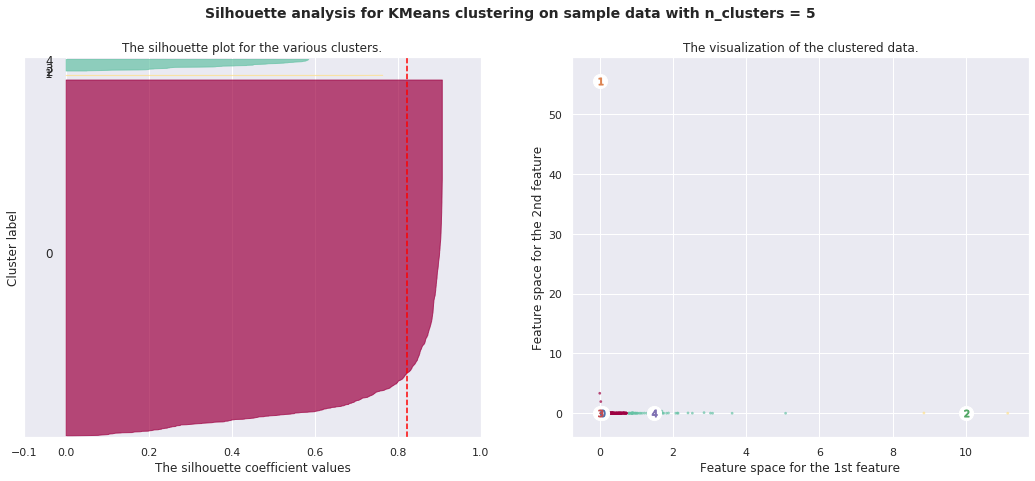

For n_clusters = 10 The average silhouette_score is : 0.675245182891558


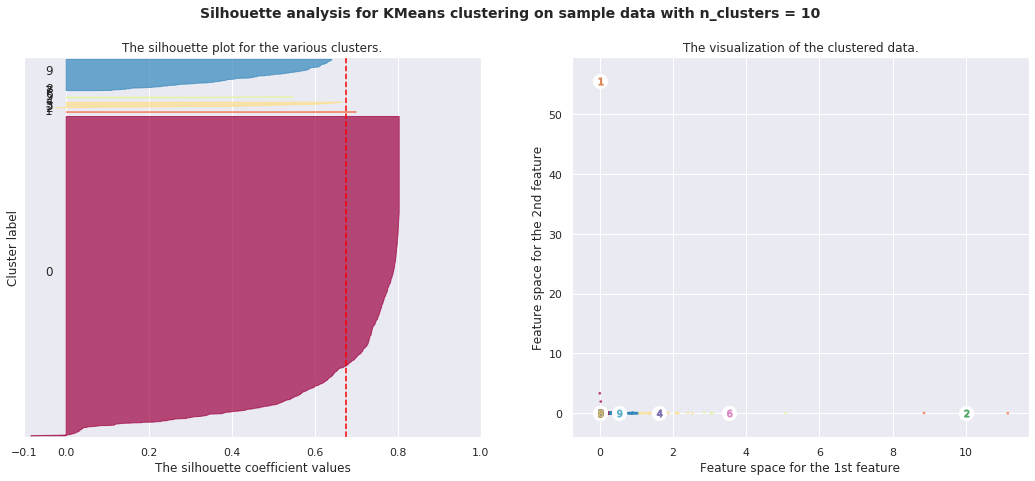

For n_clusters = 20 The average silhouette_score is : 0.6039707933352157


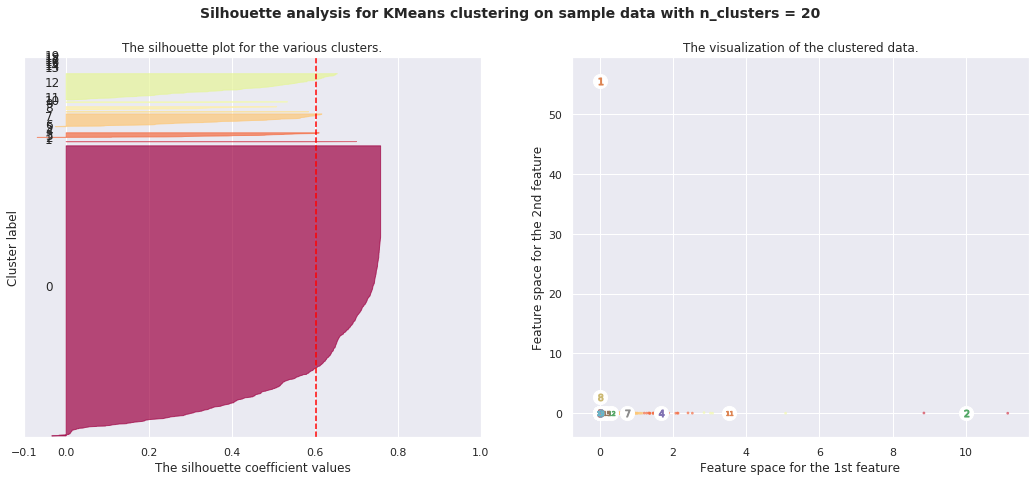

For n_clusters = 50 The average silhouette_score is : 0.6192464781120491


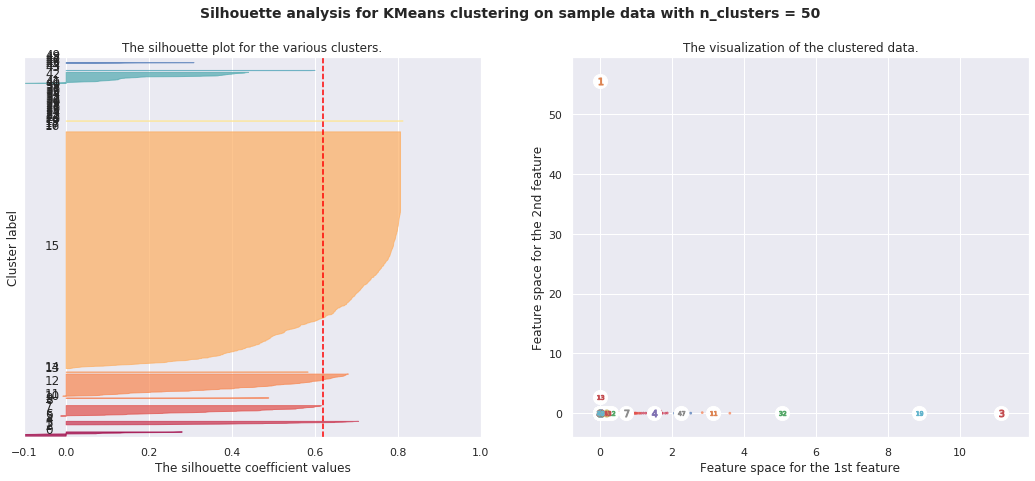

CPU times: user 6.49 s, sys: 28.3 ms, total: 6.52 s
Wall time: 9.75 s


In [90]:
%%time
range_n_clusters = [2, 3, 4, 5, 10, 20, 50]
clusterAndPlot(pd.DataFrame(W),range_n_clusters)

### MPL with one Hot Encoding

In [ ]:
%%time
# converting dataset into string dataset.
lastfm_s = lastfm.astype(str)

In [ ]:
%%time
lastfmval_s = lastfmval.astype(str)

In [ ]:
%%time
# One Hot Encoding
lastfm_one_hot = pd.get_dummies(lastfm_s)
len(lastfm_one_hot)

In [ ]:
%%time
lastfmval_one_hot = pd.get_dummies(lastfmval_s)
len(lastfmval_one_hot)

In [30]:
# Use 15% of the samples as test
X_train, X_test, Y_train, Y_test = train_test_split(lastfm_one_hot, lastfmval_one_hot, test_size=0.15)

In [ ]:
# Multi-Layer Perceptron Classifier model.
hidden_layers = (100,100,100)
print("Creating MLP classifier so formed: " + str(hidden_layers) + " with max_iter=500")
print(" ")
mlp = MLPClassifier(hidden_layer_sizes=hidden_layers, verbose=True, max_iter=500)

In [ ]:
%%time
# fit the model.
print("Start to fit the model")
print(" ")
mlp.fit(X_train, Y_train) 

In [ ]:
# make predictions.
print("Start make predictions")
print(" ")
y_pred = mlp.predict(X_test)

# we report its score (in terms of 0/1 Loss and Accuracy Score)-
print("0/1 Loss: " + str(zero_one_loss(Y_test, y_pred)))
print(" ")
print("Accuracy Score: " + str(accuracy_score(Y_test, y_pred)))
print(" ")

y_pred_prob = mlp.predict_proba(X_test)
print(y_pred_prob)

### MLP

In [60]:
# open last fm dataset (test).
filename = to_filename(dataset_name, 'test')
lastfmtest = load_dataset(filename)

Memory usage: 159853344


In [61]:
# Multi-Layer Perceptron Classifier model.
hidden_layers = (1000,1000,1000)
print("Creating MLP classifier so formed: " + str(hidden_layers) + " with max_iter=500")
print(" ")
mlp = MLPClassifier(hidden_layer_sizes=hidden_layers, verbose=True, max_iter=500)

Creating MLP classifier so formed: (1000, 1000, 1000) with max_iter=500
 


In [62]:
val = {}

#foreach row.
for i, row in lastfm.iterrows():
    val[i] = 0
    max_value = 0
    j = 0
    for item in row:
        if(item >  max_value):
            # i is the row index.
            val[i] = j
            max_value = item
        j += 1

#conversion.
#valdf = pd.DataFrame.from_dict(val, orient='index' ,columns=['y'])


In [63]:
valarr = [v for v in val.values()]

In [64]:
val_val = {}

#foreach row.
for i, row in lastfmval.iterrows():
    val_val[i] = 0
    max_value = 0
    j = 0
    for item in row:
        if(item >  max_value):
            # i is the row index.
            val_val[i] = j
            max_value = item

        j += 1
    
#val_valdf = pd.DataFrame.from_dict(val_val, orient='index' ,columns=['y'])


In [65]:
val_valarr = [v for v in val_val.values()]

In [66]:
val_test = {}

#foreach row.
for i, row in lastfmtest.iterrows():
    val_test[i] = 0
    max_value = 0
    j = 0
    for item in row:
        if(item >  max_value):
            # i is the row index.
            val_test[i] = j
            max_value = item

        j += 1
    
#val_testdf = pd.DataFrame.from_dict(val_test, orient='index' ,columns=['y'])


In [67]:
val_testarr = [v for v in val_test.values()]

In [68]:
%%time
# fit the model.
print("Start to fit the model")
print(" ")
mlp.fit(lastfm, valarr)

Start to fit the model
 
Iteration 1, loss = 6.51904236
Iteration 2, loss = 4.64864444
Iteration 3, loss = 3.84490532
Iteration 4, loss = 3.20409066
Iteration 5, loss = 2.52948873
Iteration 6, loss = 1.85488442
Iteration 7, loss = 1.34410889
Iteration 8, loss = 0.91088030
Iteration 9, loss = 0.51169062
Iteration 10, loss = 0.32742479
Iteration 11, loss = 0.33366860
Iteration 12, loss = 0.30163188
Iteration 13, loss = 0.09852368
Iteration 14, loss = 0.07349625
Iteration 15, loss = 0.05914429
Iteration 16, loss = 0.05622455
Iteration 17, loss = 0.03912037
Iteration 18, loss = 0.04917966
Iteration 19, loss = 0.03440342
Iteration 20, loss = 0.02691501
Iteration 21, loss = 0.01219787
Iteration 22, loss = 0.00689613
Iteration 23, loss = 0.00541957
Iteration 24, loss = 0.00465143
Iteration 25, loss = 0.00418846
Iteration 26, loss = 0.00391026
Iteration 27, loss = 0.00361867
Iteration 28, loss = 0.00351921
Iteration 29, loss = 0.00337125
Iteration 30, loss = 0.00328481
Iteration 31, loss = 0.0

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(1000, 1000, 1000), learning_rate='constant',
              learning_rate_init=0.001, max_iter=500, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False)

In [69]:
# make predictions
print(" ")
print("Start make predictions")
print(" ")
y_pred = mlp.predict(lastfm)

# we report its score (in terms of 0/1 Loss and Accuracy Score)
print("0/1 Loss: " + str(zero_one_loss(val_valarr, y_pred)))
print(" ")
print("Accuracy Score: " + str(accuracy_score(val_valarr, y_pred)))
print(" ")

predict_prob_m = mlp.predict_proba(lastfmval)
print(predict_prob_m)

 
Start make predictions
 
0/1 Loss: 0.8391824141920555
 
Accuracy Score: 0.16081758580794447
 
[[9.99936455e-01 1.86681554e-06 5.70122006e-09 ... 1.81415045e-12
  4.74333716e-10 1.00465176e-12]
 [8.05954684e-56 7.11574744e-31 1.88026737e-30 ... 1.00169912e-22
  2.18309025e-25 6.34125817e-48]
 [6.79699892e-14 6.22322113e-09 1.48823385e-10 ... 1.44280183e-10
  6.97414013e-10 2.45986783e-20]
 ...
 [9.99936455e-01 1.86681554e-06 5.70122006e-09 ... 1.81415045e-12
  4.74333716e-10 1.00465176e-12]
 [9.99936455e-01 1.86681554e-06 5.70122006e-09 ... 1.81415045e-12
  4.74333716e-10 1.00465176e-12]
 [9.99936455e-01 1.86681554e-06 5.70122006e-09 ... 1.81415045e-12
  4.74333716e-10 1.00465176e-12]]


In [70]:
# calculate test dataset hits.
total_item_distinct_consumption, total_item_distinct_consumption_mean, test_hits = calculate_hits(lastfmval)

In [71]:
# take first five hits.
first_five = [0,0,0,0,0]
first_five_indexes = [0,0,0,0,0]

i = 0
#foreach index.
for hit_i in test_hits:
        
    # if the hit is greater than min_hit.
    if(test_hits[hit_i] > first_five[0]):
                
        first_five[0] = test_hits[hit_i]
        first_five_indexes[0] = hit_i
        
        if(test_hits[hit_i] > first_five[1]):
            
            first_five[0], first_five[1] = first_five[1], first_five[0]
            first_five_indexes[0], first_five_indexes[1] = first_five_indexes[1], first_five_indexes[0]

            if(test_hits[hit_i] > first_five[2]):
                
                first_five[1], first_five[2] = first_five[2], first_five[1]
                first_five_indexes[1], first_five_indexes[2] = first_five_indexes[2], first_five_indexes[1]

                
                if(test_hits[hit_i] > first_five[3]):
                        
                    first_five[2], first_five[3] = first_five[3], first_five[2]
                    first_five_indexes[2], first_five_indexes[3] = first_five_indexes[3], first_five_indexes[2]

                    if(test_hits[hit_i] > first_five[4]):
                                   
                        first_five[3], first_five[4] = first_five[4], first_five[3]
                        first_five_indexes[3], first_five_indexes[4] = first_five_indexes[4], first_five_indexes[3]

first_five, first_five_indexes       

([90, 97, 105, 157, 495], [0, 253, 417, 23, 233])

In [72]:
# number of CHOSEN items that are consumed (by the single user) in the test set.
consumed = 0
# number of CHOSEN items that are consumed (by the single user) in the test set more than 10 times.
consumed10 = 0

#foreach row inside test set..
for i, row in lastfmtest.iterrows():
    
    # take feature index.
    index = y_pred[i]
    
    # if the feature was consumed.
    if(row[index] > 0):
        
        consumed +=1
        
        # if the feature was consumed more than 10 times.
        if(row[index] >= 10):
            consumed10 += 1
    
    # was not consumed.
    else:
        
        ok = False

        # check it were consumed.
        for hit_index in first_five_indexes:
            
            
            if(ok== True):
                # exit: we won't count more than one time an hit.
                break
            
            if(row[hit_index] > 0):
                consumed +=1
                
                ok = True
                
                if(row[hit_index] >= 10):
                    consumed10 +=1
    
print("Accuracy with hit help: " + str(consumed/len(lastfm)) + "%")
print("Accuracy with hit help for a consume >= 10:" + str(consumed10/len(lastfm))+ "%")

Accuracy with hit help: 0.2510605476282298%
Accuracy with hit help for a consume >= 10:0.006556112610875434%
